## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

## <span style="color:darkred">Avaliação Final</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

Notebook resolvido por Arion Melkan de Freitas

Nessa avaliação será utilizado o dataset `creditcard.csv` que contém 31 colunas. Esse problema é o de detectar fraude em transações em cartões de crédito. Vamos assumir um cenário com alta disponibilidade de exemplos não rotulados, e baixa de exemplos rotulados. Para tal, pré-treinaremos camadas de uma rede neural com dados não anotados, a qual posteriormente será usada para compor um modelo inicial de classificação.<br><br>

<font color="blue">
Você deverá criar um notebook (ipynb) com a solução. O Notebook deverá conter as saídas para visualização dos resultados. Fazer upload no Moodle de 2 arquivos:</font>

<font color="blue">1. Notebook com o código fonte (ipynb)</font><br>
<font color="blue">2. Versão em PDF com todos os resultados</font>

Conforme código abaixo, use como características de entrada as colunas de posição 1 até 28 (marcadas no arquivo como V1 - V28), e como classe a última coluna (Class). Não utilize a coluna Amount.

As tarefas a realizar são as seguintes:

1. **Separe** os dados em:
    * conjunto S = 2,5% dos dados iniciais como treinamento com rótulo (assumiremos que temos rótulos apenas para esses 2,5%, ou 7120 exemplos), no formato par (x,y)
    * conjunto U = 50% dos dados iniciais como treinamento não anotado (note que S está contido em U), 
    * conjunto T = o restante dos 50% para teste, no formato par (x,y).<br><br>
1. **Modelo A**: denoising overcomplete autoencoder para pré-treinamento baseado em auto-supervisão
    * Arquitetura com as seguintes camadas:
        * entrada com 28 valores
        * normalização em batch
        * densa 32 neurônios, relu
        * densa 32 neurônios, relu
        * dropout 0.2
        * normalização em batch
        * densa 28 neurônios, relu (camada de código/bottleneck)
        * densa 32 neurônios, relu
        * densa 32 neurônios, relu
        * densa 28 neurônios, tanh
    * Inserção de ruído aleatório uniforme ponderado a 0.2 (insira ruído nos dados de treinamento fornecidos por entrada, mas mantenha a comparação com a saída sem ruído, como num denoising autoencoder)
    * Taxa de aprendizado inicial de 0.003 e com decaimento a partir da época 5, exponencial a -0.2
    * Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto **U**<br><br>
1. **Análise de projeção das características**: visualize um scatterplot com os 2 principais componentes obtidos do PCA com as classes dos exemplos atribuídas com cores ou marcadores diferentes:
    * scatterplot com projeção PCA do conjunto de S original
    * scatterplot com projeção PCA do conjunto S após processado pelo "encoder", ou seja resultado da saída da camada de código<br><br>
    
1. **Modelo B**: rede neural profunda densa, utilizando como base o encoder do modelo A, e inserindo uma nova camada densa de classificação com ativação sigmóide.<br>
    * Taxa de aprendizado inicial de 0.001 e com decaimento em todas as épocas exponencial a -0.3
    * Uso de pesos para as classes: 0.1 para classe 0 (majoritária), e 0.9 para a classe 1 (minoritária)
    * Treinar com perda MSE por 8 épocas com batch size 16 
    * Compute como métricas, além da perda, precisão e revocação (precision / recall)<br><br>
    
1. **Avalie a rede neural de classificação**: 
    * Exiba o gráfico da precisão e revocação no treinamento calculada ao longo das épocas
    * Exiba precisão e revocação calculada no treinamento S e teste T
    * Exiba um scatterplot do conjunto S obtendo sua representação do código da rede de classificação (saída da camada com 28 exemplos)<br><br>

1. **Bônus:** (+1 ponto extra) compare a solução com duas outras possibilidades que não envolvam uso do conjunto **U** não rotulado
    * Rede neural profunda com a mesma arquitetura e estratégias usadas no modelo B, mas sem usar os pesos pré-treinados, inicializando e treinando com os dados em S por 15 épocas. Avalie precisão e revocação no treinamento S e teste T.
    * Classificador SVM treinado nos dados originais S. Avalie precisão e revocação no treinamento S e teste T.
    * Classificador SVM treinado nos dados S obtendo sua representação do código da rede de classificação (modelo B). Avalie precisão e revocação no treinamento S e teste T.

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score

sns.set()

In [2]:
df = pd.read_csv("creditcard.csv")
df

Time         V1         V2  ...       V28  Amount  Class
0            0.0  -1.359807  -0.072781  ... -0.021053  149.62      0
1            0.0   1.191857   0.266151  ...  0.014724    2.69      0
2            1.0  -1.358354  -1.340163  ... -0.059752  378.66      0
3            1.0  -0.966272  -0.185226  ...  0.061458  123.50      0
4            2.0  -1.158233   0.877737  ...  0.215153   69.99      0
...          ...        ...        ...  ...       ...     ...    ...
284802  172786.0 -11.881118  10.071785  ...  0.823731    0.77      0
284803  172787.0  -0.732789  -0.055080  ... -0.053527   24.79      0
284804  172788.0   1.919565  -0.301254  ... -0.026561   67.88      0
284805  172788.0  -0.240440   0.530483  ...  0.104533   10.00      0
284806  172792.0  -0.533413  -0.189733  ...  0.013649  217.00      0

[284807 rows x 31 columns]

In [3]:
print(f'Linhas e colunas do dataframe: {df.shape}')

Linhas e colunas do dataframe: (284807, 31)


### Parte 1: separar dados

In [4]:
# Este método serve para separação da classe
def SeparacaoClasse(data = df, target = 'Class', begin_feat = 0, end_feat = 0):
  # Separando meu atributo target dos demais atributos - Já estou tratando, conforme recomendação, utilizar os atributos do V1 à V28
  features = list(data.columns)[begin_feat:end_feat]

  # Separando os conjuntos
  X = data[features]
  y = data[target]

  # Conferindo se os formatos estão corretos
  print(f'{X.shape}\n{y.shape}\n')
    
  return X, y

In [5]:
# Método de dividir em treino e teste para evitar código duplicado
def HoldOut(X_hold_out = '', y_hold_out = '', test_size = 0, retornar_treino_teste = True):
  # Separando o conjunto de treinamento e de testes - Utilizando a técnica Hold Out
  X_train, X_test, y_train, y_test = train_test_split(X_hold_out, y_hold_out, test_size=test_size, random_state=0, shuffle=False)

  # Realizo uma condição para o cenário de retornar apenas o conjunto S do U
  if (retornar_treino_teste):
    # Verificando se está tudo certo
    print(f'O conjunto de treino - olhando as features: {X_train.shape}')
    print(f'O conjunto de teste  - olhando as features: {X_test.shape}')
    print(f'O conjunto de treino - olhando a classe   : {y_train.shape}')
    print(f'O conjunto de teste  - olhando a classe   : {y_test.shape}')

    # Retornando os dados  
    return X_train, X_test, y_train, y_test

  else:
    # Exibir mensagem
    print(f'\nA quantidade de exemplo para features e colunas para o novo '
          f'conjunto é de: {X_train.shape}\n'
          f'E a quantidade de exemplo para classe do novo conjunto é de: '
          f'{y_train.shape}')
    
    # Retornando os dados
    return X_train, y_train

In [6]:
#### Chamando o método SeparacaoClasse
target     = 'Class'
begin_feat = 1
end_feat   = 29

X, y = SeparacaoClasse(df, target, begin_feat, end_feat)

# Agora formarei os conjuntos U (Treinamento) e T (Teste)
test_size    = 0.5
treino_teste = True

# Chamando o método HoldOut
U_x, T_x, U_y, T_y = HoldOut(X, y, test_size, treino_teste)

# E, finalmente, formarei o conjunto que consideraremos com rótulos, o conjunto S
# Por estar na técnica do hold out o parâmetro de test_size, eu precisei deixar 95% dos dados do conjunto U em "teste"
# E recuperar apenas os 5% que dão os 7.120 exemplos necessários.
test_size    = 1 - 0.05
treino_teste = False

# Conforme definido, eu utilizei o conjunto U para formar o conjunto S, visto que S está contido em U.
# Eu poderia realizar
S_x, S_y = HoldOut(U_x, U_y, test_size, treino_teste)

(284807, 28)
(284807,)

O conjunto de treino - olhando as features: (142403, 28)
O conjunto de teste  - olhando as features: (142404, 28)
O conjunto de treino - olhando a classe   : (142403,)
O conjunto de teste  - olhando a classe   : (142404,)

A quantidade de exemplo para features e colunas para o novo conjunto é de: (7120, 28)
E a quantidade de exemplo para classe do novo conjunto é de: (7120,)


### Parte 2: Modelo A

In [7]:
#### Método que cria o modelo autoencoder overcomplete
def MyAutoencoder(input_shape, neurons_a = 32, neurons_b = 28, activ_a = 'relu', activ_b = 'tanh'):
  # Encoder
  # Entrada com 28 valores
  entrada = layers.Input(shape=(input_shape), name='input_encoder')

  # Normalização em batch
  e1 = layers.BatchNormalization(name='e1_BN')(entrada)

  # Densa 32 neurônios, relu
  e2 = layers.Dense(neurons_a, activation=activ_a, name='e2_densa_1')(e1)

  # Densa 32 neurônios, relu
  e3 = layers.Dense(neurons_a, activation=activ_a, name='e3_densa_2')(e2)

  # dropout 0.2
  e4 = layers.Dropout(2e-1)(e3)

  # Normalização em batch
  e5 = layers.BatchNormalization(name='e5_BN')(e4)

  # Densa 28 neurônios, relu (camada de código/bottleneck) - Transição do encoder para decoder
  cod = layers.Dense(neurons_b, activation=activ_a, name='code')(e5)

  # Decoder
  # Densa 32 neurônios, relu
  d1 = layers.Dense(neurons_a, activation=activ_a, name='d1_densa_1')(cod)
  
  # Densa 32 neurônios, relu
  d2 = layers.Dense(neurons_a, activation=activ_a, name='d2_densa_2')(d1)
  
  # Densa 28 neurônios, tanh
  d3 = layers.Dense(neurons_b, activation=activ_b, name='d3_densa_3')(d2)

  autoencoder = models.Model(entrada, d3)
  autoencoder.summary()

  return autoencoder

In [8]:
#### Inserção de ruído aleatório uniforme ponderado a 0.2 (insira ruído nos dados de treinamento fornecidos por entrada, 
# mas mantenha a comparação com a saída sem ruído, como num denoising autoencoder)
noiseFactor = 2e-1

# Adicionando ruído no conjunto U de treinamento e de testes
XtrainNoise = U_x + noiseFactor * np.random.uniform(0, 1, U_x.shape)

print(f'Treino = {XtrainNoise.shape}.')

Treino = (142403, 28).


In [9]:
#### Insiro o treino com ruído no denoising autoencoder
neuron_a = 32
neuron_b = 28
activa_a = 'relu'
activa_b = 'tanh'

# Inicializando as sementes para ter reproducibilidade
seed(1)
set_seed(2)

# Modelo base gerado do método MyAutoencoder
model_bs_a = MyAutoencoder(U_x.shape[1], neuron_a, neuron_b, activa_a, activa_b);

# Nesse momento estou clonando o meu modelo_a base para verificar os diferentes cenários
# de otimizadores e escolher, entre eles, o que teve pouca perda.
# Modelo com o otimizador ADAM
model_a_adam = models.clone_model(model_bs_a)

# Modelo com o otimizador SGD sem Momentum
model_a_sgd  = models.clone_model(model_bs_a)

# Modelo com o otimizador SGD com Momentum 0.7
mdl_a_sgd_m7 = models.clone_model(model_bs_a)

# Modelo com o otimizador SGD com Momentum 0.9
mdl_a_sgd_m9 = models.clone_model(model_bs_a)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_encoder (InputLayer)   [(None, 28)]              0         
_________________________________________________________________
e1_BN (BatchNormalization)   (None, 28)                112       
_________________________________________________________________
e2_densa_1 (Dense)           (None, 32)                928       
_________________________________________________________________
e3_densa_2 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
e5_BN (BatchNormalization)   (None, 32)                128       
_________________________________________________________________
code (Dense)                 (None, 28)               

In [10]:
# Método que mapeia o número de épocas e modifica o learning rate, após uma certa época
# Taxa de aprendizado inicial de 0.003 e com decaimento a partir da época 5, exponencial a -0.2
def scheduler(epochs, lr):
  if epochs < 5:
    return lr
  else:
    return np.clip(lr * tf.math.exp(-2e-1), 1e-5, 1e-3)

callbacklr = keras.callbacks.LearningRateScheduler(scheduler)

In [11]:
# Criando método que compila o modelo e o treina, gerando o seu histórico - para evitar código duplicado
def ModeloCompilaTreina(model, x, y, loss, batchSize, numberEpochs, callbk, opt, exe_metric, lst_metrics, exe_weight, dc_weight):
  # Inicializando as sementes para ter reproducibilidade
  seed(1)
  set_seed(2)

  # Compilando o modelo com ou sem métricas adicionais
  if (exe_metric):
    model.compile(loss=loss, optimizer=opt, metrics=lst_metrics)
  else:
    model.compile(loss=loss, optimizer=opt)

  # Treinando o modelo com ou sem peso
  if (exe_weight):
    hist_model = model.fit(x=x, y=y, batch_size=batchSize, shuffle=True,
            epochs=numberEpochs, verbose=1, callbacks=[callbk], class_weight=dc_weight);
  else:
    hist_model = model.fit(x=x, y=y, batch_size=batchSize, shuffle=True,
            epochs=numberEpochs, verbose=1, callbacks=[callbk]);

  # Retorna o histórico do treinamento em cada época
  return hist_model

**Cenário com o otimizador SGD - Stochastic Gradient Descend**

In [12]:
# Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto U
# Com taxa de aprendizado inicial por 0.003 ou 3e-3
lr = 3e-3
loss = 'mse'
batchSize = 16
numberEpochs = 20
opt = keras.optimizers.SGD(lr)
exe_metric = False
exe_weight = False
metrics = ['']
dc_weight = {}

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
hist_sgd = ModeloCompilaTreina(model_a_sgd, XtrainNoise, U_x, loss, batchSize, numberEpochs, callbacklr, opt, 
                               exe_metric, metrics, exe_metric, dc_weight)

Epoch 1/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.9874
Epoch 2/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.8792
Epoch 3/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.8042
Epoch 4/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.7618
Epoch 5/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.7327
Epoch 6/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.7175
Epoch 7/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.7109
Epoch 8/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.7067
Epoch 9/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.7027
Epoch 10/20
8901/8901 [==============================] - 12s 1ms/step - loss: 0.7004
Epoch 11/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.6977
Epoch 12/20
8901/8901 [==============================] - 11s 1ms/step - lo

**Cenário com o otimizador SGD - Stochastic Gradient Descend + Momentum 0.7**

In [13]:
# Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto U
# Com taxa de aprendizado inicial por 0.003 ou 3e-3
lr = 3e-3
loss = 'mse'
batchSize = 16
numberEpochs = 20
opt = keras.optimizers.SGD(lr, momentum=7e-1)
exe_metric = False
exe_weight = False
metrics = ['']
dc_weight = {}

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
hist_sgd_m7 = ModeloCompilaTreina(mdl_a_sgd_m7, XtrainNoise, U_x, loss, batchSize, numberEpochs, callbacklr, opt,
                                  exe_metric, metrics, exe_weight, dc_weight)

Epoch 1/20
8901/8901 [==============================] - 12s 1ms/step - loss: 0.8887
Epoch 2/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.7411
Epoch 3/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.6872
Epoch 4/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.6566
Epoch 5/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.6350
Epoch 6/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.6234
Epoch 7/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.6186
Epoch 8/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.6155
Epoch 9/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.6124
Epoch 10/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.6109
Epoch 11/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.6086
Epoch 12/20
8901/8901 [==============================] - 11s 1ms/step - lo

**Cenário com o otimizador SGD - Stochastic Gradient Descend + Momentum 0.9**

In [14]:
# Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto U
# Com taxa de aprendizado inicial por 0.003 ou 3e-3
lr = 3e-3
loss = 'mse'
batchSize = 16
numberEpochs = 20
opt = keras.optimizers.SGD(lr, momentum=9e-1)
exe_metric = False
exe_weight = False
metrics = ['']
dc_weight = {}

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
hist_sgd_m9 = ModeloCompilaTreina(mdl_a_sgd_m9, XtrainNoise, U_x, loss, batchSize, numberEpochs, callbacklr, opt, 
                                  exe_metric, metrics, exe_weight, dc_weight)

Epoch 1/20
8901/8901 [==============================] - 12s 1ms/step - loss: 0.7763
Epoch 2/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.6347
Epoch 3/20
8901/8901 [==============================] - 12s 1ms/step - loss: 0.5940
Epoch 4/20
8901/8901 [==============================] - 13s 1ms/step - loss: 0.5740
Epoch 5/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.5619
Epoch 6/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.5508
Epoch 7/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.5470
Epoch 8/20
8901/8901 [==============================] - 12s 1ms/step - loss: 0.5445
Epoch 9/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.5427
Epoch 10/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.5412
Epoch 11/20
8901/8901 [==============================] - 11s 1ms/step - loss: 0.5401
Epoch 12/20
8901/8901 [==============================] - 11s 1ms/step - lo

**Cenário com o otimizador Adam**

In [15]:
# Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto U
# Com taxa de aprendizado inicial por 0.003 ou 3e-3
lr = 3e-3
loss = 'mse'
batchSize = 16
numberEpochs = 20
opt = keras.optimizers.Adam(lr)
exe_metric = False
exe_weight = False
metrics = ['']
dc_weight = {}

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
hist_adam = ModeloCompilaTreina(model_a_adam, XtrainNoise, U_x, loss, batchSize, numberEpochs, callbacklr, opt, 
                                exe_metric, metrics, exe_weight, dc_weight)

Epoch 1/20
8901/8901 [==============================] - 14s 2ms/step - loss: 0.5960
Epoch 2/20
8901/8901 [==============================] - 15s 2ms/step - loss: 0.5399
Epoch 3/20
8901/8901 [==============================] - 15s 2ms/step - loss: 0.5286
Epoch 4/20
8901/8901 [==============================] - 14s 2ms/step - loss: 0.5239
Epoch 5/20
8901/8901 [==============================] - 14s 2ms/step - loss: 0.5206
Epoch 6/20
8901/8901 [==============================] - 15s 2ms/step - loss: 0.5064
Epoch 7/20
8901/8901 [==============================] - 15s 2ms/step - loss: 0.5032
Epoch 8/20
8901/8901 [==============================] - 15s 2ms/step - loss: 0.5021
Epoch 9/20
8901/8901 [==============================] - 16s 2ms/step - loss: 0.5002
Epoch 10/20
8901/8901 [==============================] - 14s 2ms/step - loss: 0.5000
Epoch 11/20
8901/8901 [==============================] - 15s 2ms/step - loss: 0.4989
Epoch 12/20
8901/8901 [==============================] - 16s 2ms/step - lo

In [16]:
# Método que plota os history dos modelos - evitar de duplicar código
def PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel):
  # Configurando o tamanho da figura
  plt.figure(figsize=(8,5))

  # Percorre a minha lista com o history de cada versão do modelo
  for p in lst_hist:
    plt.plot(p);

  plt.legend(legend, loc = location);
  plt.xlabel(xlabel);
  plt.ylabel(ylabel);
  plt.show();

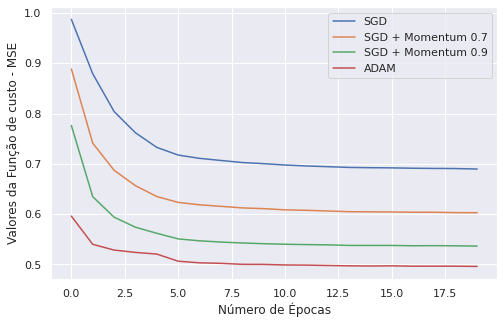

In [17]:
# Inicializando as variáveis
map_metric = 'loss'
lst_hist = [hist_sgd.history[map_metric], hist_sgd_m7.history[map_metric],
            hist_sgd_m9.history[map_metric], hist_adam.history[map_metric]]
legend = ["SGD", "SGD + Momentum 0.7", "SGD + Momentum 0.9", "ADAM"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores da Função de custo - MSE'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

Segundo o resultado no gráfico acima, o SGD sem momentum foi o que teve a maior perda. Posteriormente, inserí a técnica do momentum primeiro com 0.7 e depois com 0.9 no SGD, reduzindo a perda. O SGD com momentum 0.9, em comparação com outros SGDs, foi o que teve a menor perda.

Não inserí mais valores no momentum, pois demanda tempo em cada execução e o intuito era ter mais a noção do que ocorreria adicionando dois momentum com valores próximos.

No final, mudei o otimizador colocando o ADAM e obtive o modelo A com a menor perda do MSE.


Utilizarei o modelo com o otimizador ADAM por apresentar menor perda.

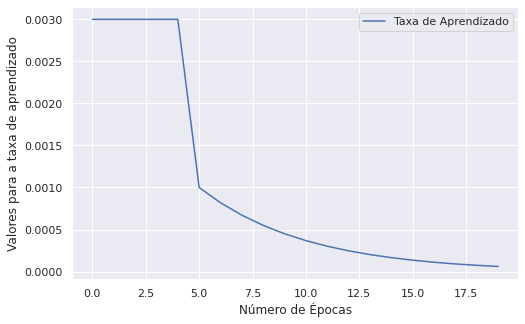

In [18]:
# Inicializando as variáveis
map_metric = 'lr'
lst_hist = [hist_adam.history[map_metric]]
legend = ["Taxa de Aprendizado"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores para a taxa de aprendizado'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

Criei um gráfico da taxa de aprendizado apenas para entender se a taxa não permaneceu a mesma durante as épocas, pois eu estava mapeando os valores durante o treinamento e quis deixar mais ajustado ao invés de deixar junto com a informação de cada época e o custo do MSE.
<br><br>

Observação: Um dos motivos que eu substituí o np.round por np.clip, foi porque mesmo arredondando para 4 casas decimais, a taxa de aprendizado, nas últimas três épocas, ficava o mesmo valor. Diferente do np.clip, onde até a vigésima época obtive taxa de aprendizado "única".

### Parte 3: Análise da projeção das características

In [19]:
#### Scatterplot com projeção PCA do conjunto de S original
# Convertendo os dados de treino para padronização
X_train_scaled = S_x.copy(deep=True)

scaler = StandardScaler()
scaler.fit(S_x)
X_train_scaled.iloc[:, :] = scaler.transform(S_x)

In [20]:
# Método responsável por exibir o PCA após geração do modelo
def ShowModelPCA(camada, model, X_train, y_train, exe_model):
  # Inicializando as sementes para ter reproducibilidade
  seed(1)
  set_seed(2)

  # Configurando o tamanho da figura
  fig = plt.figure(figsize=(8,5))

  # Condição para avaliar se executará o pca com o modelo ou sem o modelo
  if (exe_model):
    # Gerando o modelo com a entrada do modelo e a saída a camada bottleneck
    extract = models.Model(model.input, model.get_layer(camada).output)

    # Realizando a predição do conjunto X_train
    featuresTest = np.array(extract.predict(X_train))

  else:
    featuresTest = X_train.values
  
  # Comum para as duas condições
  pca_result = PCA(n_components=2, random_state=1).fit_transform(featuresTest)

  sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=y_train, palette='Set2');
  plt.show();

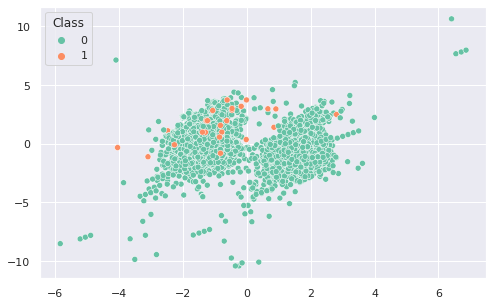

In [21]:
# Inicializando as variáveis
exe_model = False

# Chamando o método de exibir o pca
ShowModelPCA('', '', X_train_scaled, S_y, exe_model)

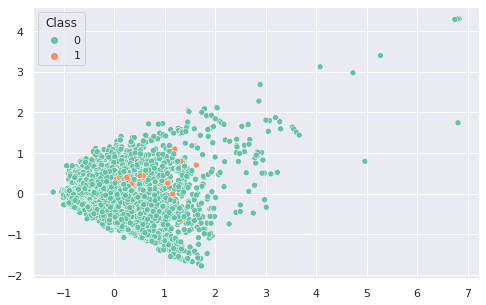

In [22]:
# Inicializando as variáveis
camada = 'code'
model  = model_a_adam
exe_model = True

# Chamando o método de exibir o pca do modelo
ShowModelPCA(camada, model, S_x, S_y, exe_model)

### Parte 4: Modelo B

In [23]:
#### Construir o modelo B - gerando um método para evitar duplicação de código
def RedeNeuralDensa(model = model_bs_a, camada = 'code', neurons = 1, activ = 'sigmoid'):
  # Obtendo a saída da camada de código do modelo A (camada bottleneck)
  base_encoder = model.get_layer(camada).output

  # Criando uma nova camada de saída que recebe como entrada a anterior
  saida_nova = layers.Dense(neurons, activation=activ, name='dense_out_b')(base_encoder)

  # Criando um novo modelo tendo essa nova camada como saída
  model_b = models.Model(model.inputs, saida_nova)

  # Modelo final
  model_b.summary()

  return model_b

**Utilizarei o "modelo a base" para explorar na 4ª questão qual melhor otimizador para esse modelo b criado e se ocorre alguma mudança na escolha do otimizador.<br>
Segundo o professor, nós temos a opção de escolher se adotaremos os pesos dos modelos já pré treinados ou não, embora a sexta questão delimita que não adotemos os pesos pré treinados do modelo A e pode acontecer de sair o mesmo modelo gerado tanto na quarta quanto na sexta questão.**

In [24]:
# Realizando o clone do modelo a base, evitando treinar o modelo base e ser usado em outro momento
model = models.clone_model(model_bs_a)
camada = 'code'
neurons = 1
activ = 'sigmoid'

# Indicando se o modelo b terá pesos pré treinados do modelo a
# False significa que vem os pesos já treinados
# True significa que os pesos serão treináveis.
model.trainable = True

# Inicializando as sementes para ter reproducibilidade
seed(1)
set_seed(2)

model_bs_b = RedeNeuralDensa(model, camada, neurons, activ)

# Nesse momento estou clonando o meu modelo_b base para verificar os diferentes cenários
# de otimizadores e escolher, entre eles, o que teve pouca perda.
# Modelo com o otimizador ADAM
model_b_adam = models.clone_model(model_bs_b)

# Modelo com o otimizador SGD sem Momentum
model_b_sgd  = models.clone_model(model_bs_b)

# Modelo com o otimizador SGD com Momentum 0.7
mdl_b_sgd_m7 = models.clone_model(model_bs_b)

# Modelo com o otimizador SGD com Momentum 0.9
mdl_b_sgd_m9 = models.clone_model(model_bs_b)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_encoder (InputLayer)   [(None, 28)]              0         
_________________________________________________________________
e1_BN (BatchNormalization)   (None, 28)                112       
_________________________________________________________________
e2_densa_1 (Dense)           (None, 32)                928       
_________________________________________________________________
e3_densa_2 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
e5_BN (BatchNormalization)   (None, 32)                128       
_________________________________________________________________
code (Dense)                 (None, 28)               

In [25]:
# Taxa de aprendizado inicial de 0.001 e com decaimento em todas as épocas exponencial a -0.3
def scheduler_b(epochs, lr):
  if epochs < 1:
    return lr
  else:
    return np.clip(lr * tf.math.exp(-3e-1), 1e-5, 1e-3)

callbacklr_b = keras.callbacks.LearningRateScheduler(scheduler_b)

**Cenário com otimizador SGD**

In [26]:
# Uso de pesos para as classes: 0.1 para classe 0 (majoritária), e 0.9 para a classe 1 (minoritária)
# Treinar com perda MSE por 8 épocas com batch size 16
# Compute como métricas, além da perda, precisão e revocação (precision / recall)
lr = 1e-3
loss = 'mse'
batchSize = 16
numberEpochs = 8
opt = keras.optimizers.SGD(lr)
exe_metric = True
exe_weight = True
metrics = [keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
dc_weight = {0:1e-1, 1:9e-1}

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
hist_b_sgd = ModeloCompilaTreina(model_b_sgd, S_x, S_y, loss, batchSize, numberEpochs, 
                                 callbacklr_b, opt, exe_metric, metrics, exe_weight, dc_weight)

Epoch 1/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0303 - precision: 0.0011 - recall: 0.1600
Epoch 2/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0288 - precision: 0.0023 - recall: 0.3200
Epoch 3/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0281 - precision: 0.0024 - recall: 0.3200
Epoch 4/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0275 - precision: 0.0019 - recall: 0.2400
Epoch 5/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0270 - precision: 0.0019 - recall: 0.2400
Epoch 6/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0268 - precision: 0.0017 - recall: 0.2000
Epoch 7/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0265 - precision: 0.0013 - recall: 0.1600
Epoch 8/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0262 - precision: 0.0014 - recall: 0.1600


**Cenário com otimizador SGD + momentum 0.7**

In [27]:
# Uso de pesos para as classes: 0.1 para classe 0 (majoritária), e 0.9 para a classe 1 (minoritária)
# Treinar com perda MSE por 8 épocas com batch size 16
# Compute como métricas, além da perda, precisão e revocação (precision / recall)
lr = 1e-3
loss = 'mse'
batchSize = 16
numberEpochs = 8
opt = keras.optimizers.SGD(lr, momentum=7e-1)
exe_metric = True
exe_weight = True
metrics = [keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
dc_weight = {0:1e-1, 1:9e-1}

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
hist_b_sgd_m7 = ModeloCompilaTreina(mdl_b_sgd_m7, S_x, S_y, loss, batchSize, numberEpochs, 
                                 callbacklr_b, opt, exe_metric, metrics, exe_weight, dc_weight)

Epoch 1/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0277 - precision: 0.0023 - recall: 0.3200
Epoch 2/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0243 - precision: 0.0017 - recall: 0.2000
Epoch 3/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0218 - precision: 0.0030 - recall: 0.2800
Epoch 4/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0202 - precision: 0.0020 - recall: 0.1600
Epoch 5/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0193 - precision: 0.0040 - recall: 0.2800
Epoch 6/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0183 - precision: 0.0044 - recall: 0.2800
Epoch 7/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0179 - precision: 0.0060 - recall: 0.3600
Epoch 8/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0177 - precision: 0.0053 - recall: 0.3200


**Cenário com otimizador SGD + momentum 0.9**

In [28]:
# Uso de pesos para as classes: 0.1 para classe 0 (majoritária), e 0.9 para a classe 1 (minoritária)
# Treinar com perda MSE por 8 épocas com batch size 16
# Compute como métricas, além da perda, precisão e revocação (precision / recall)
lr = 1e-3
loss = 'mse'
batchSize = 16
numberEpochs = 8
opt = keras.optimizers.SGD(lr, momentum=9e-1)
exe_metric = True
exe_weight = True
metrics = [keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
dc_weight = {0:1e-1, 1:9e-1}

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
hist_b_sgd_m9 = ModeloCompilaTreina(mdl_b_sgd_m9, S_x, S_y, loss, batchSize, numberEpochs, 
                                 callbacklr_b, opt, exe_metric, metrics, exe_weight, dc_weight)

Epoch 1/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0231 - precision: 0.0079 - recall: 0.8000
Epoch 2/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0157 - precision: 0.0147 - recall: 0.7600
Epoch 3/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0122 - precision: 0.0168 - recall: 0.5200
Epoch 4/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0104 - precision: 0.0261 - recall: 0.5200
Epoch 5/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0093 - precision: 0.0321 - recall: 0.4800
Epoch 6/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0084 - precision: 0.0530 - recall: 0.6000
Epoch 7/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0084 - precision: 0.0397 - recall: 0.4000
Epoch 8/8
445/445 [==============================] - 1s 1ms/step - loss: 0.0079 - precision: 0.0617 - recall: 0.5600


**Cenário com o otimizador Adam**

In [29]:
# Uso de pesos para as classes: 0.1 para classe 0 (majoritária), e 0.9 para a classe 1 (minoritária)
# Treinar com perda MSE por 8 épocas com batch size 16
# Compute como métricas, além da perda, precisão e revocação (precision / recall)
lr = 1e-3
loss = 'mse'
batchSize = 16
numberEpochs = 8
opt = keras.optimizers.Adam(lr)
exe_metric = True
exe_weight = True
metrics = [keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
dc_weight = {0:1e-1, 1:9e-1}

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
hist_b_adam = ModeloCompilaTreina(model_b_adam, S_x, S_y, loss, batchSize, numberEpochs, 
                                 callbacklr_b, opt, exe_metric, metrics, exe_weight, dc_weight)

Epoch 1/8
445/445 [==============================] - 1s 2ms/step - loss: 0.0077 - precision: 0.0184 - recall: 0.4400
Epoch 2/8
445/445 [==============================] - 1s 2ms/step - loss: 6.6630e-04 - precision: 0.7857 - recall: 0.8800
Epoch 3/8
445/445 [==============================] - 1s 2ms/step - loss: 5.5548e-04 - precision: 0.9167 - recall: 0.8800
Epoch 4/8
445/445 [==============================] - 1s 2ms/step - loss: 3.2756e-04 - precision: 0.8846 - recall: 0.9200
Epoch 5/8
445/445 [==============================] - 1s 2ms/step - loss: 3.0037e-04 - precision: 0.8846 - recall: 0.9200
Epoch 6/8
445/445 [==============================] - 1s 2ms/step - loss: 2.9926e-04 - precision: 0.8462 - recall: 0.8800
Epoch 7/8
445/445 [==============================] - 1s 2ms/step - loss: 2.0446e-04 - precision: 0.9231 - recall: 0.9600
Epoch 8/8
445/445 [==============================] - 1s 2ms/step - loss: 2.4320e-04 - precision: 0.9583 - recall: 0.9200


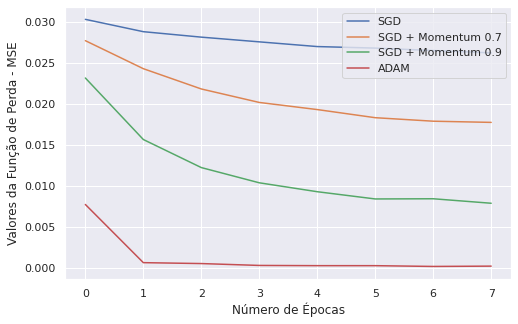

In [30]:
# Inicializando as variáveis
map_metric = 'loss'
lst_hist = [hist_b_sgd.history[map_metric], hist_b_sgd_m7.history[map_metric],
            hist_b_sgd_m9.history[map_metric], hist_b_adam.history[map_metric]]
legend = ["SGD", "SGD + Momentum 0.7", "SGD + Momentum 0.9", "ADAM"]
location = "upper right"

xlabel = 'Número de Épocas'
ylabel = 'Valores da Função de Perda - MSE'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

Analisando somente a perda, o melhor otimizador foi o ADAM.<br>
Explorando as métricas de recall e precision durante o treinamento, o otimizador ADAM também foi o que obteve melhor resultado.


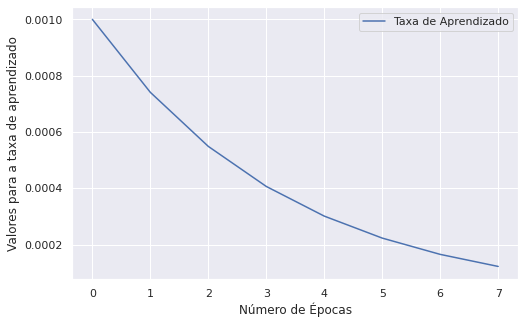

In [31]:
# Inicializando as variáveis
map_metric = 'lr'
lst_hist = [hist_b_adam.history[map_metric]]
legend = ["Taxa de Aprendizado"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores para a taxa de aprendizado'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

Apenas inserí o learning rate do modelo B graficamente para uma melhor visualização durante o treinamento.

### Parte 5: Avaliação da rede neural de classificação

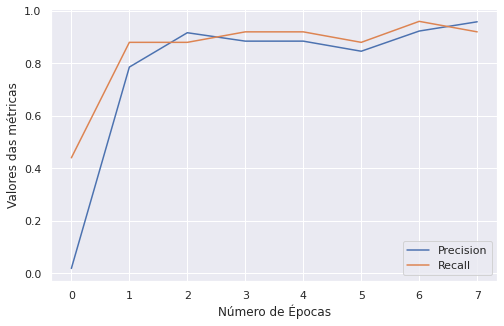

In [32]:
# Inicializando as variáveis
map_metric = ['precision', 'recall']
lst_hist = [hist_b_adam.history[map_metric[0]], hist_b_adam.history[map_metric[1]]]

legend = ["Precision", "Recall"]
location = "lower right"

xlabel = 'Número de Épocas'
ylabel = 'Valores das métricas'

PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

In [33]:
# Exiba precisão e revocação calculada no treinamento S e teste T
scoreS = model_b_adam.evaluate(S_x, S_y, verbose=0);
scoreT = model_b_adam.evaluate(T_x, T_y, verbose=0);

print(f'Cenário do Treinamento - Conjunto S:\n\tPrecisão  = '
      f'{scoreS[1]:.4f}\n\tRevocação = {scoreS[2]:.4f}\n'
      f'Cenário do Teste - Conjunto T:\n\tPrecisão  = '
      f'{scoreT[1]:.4f}\n\tRevocação = {scoreT[2]:.4f}')

Cenário do Treinamento - Conjunto S:
	Precisão  = 0.9231
	Revocação = 0.9600
Cenário do Teste - Conjunto T:
	Precisão  = 0.8233
	Revocação = 0.7937


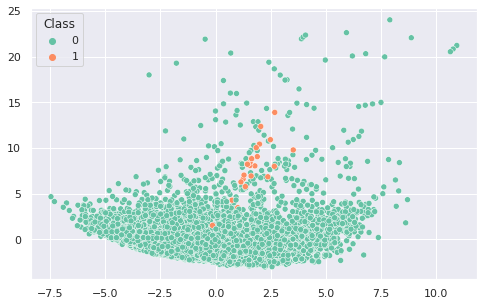

In [34]:
# Inicializando as variáveis
camada = 'code'
model  = model_b_adam
exe_model = True

# Chamando o método de exibir o pca do modelo
ShowModelPCA(camada, model, S_x, S_y, exe_model)

Os dados com fraude estão mais perceptíveis com o modelo B em relação ao modelo A, uma das razões disso é que o modelo B tem como objetivo classificar, foi aplicado a camada de saída com 1 neurônio, o dado de fraude e o dado não fraudulento. 

O modelo A foi mais um modelo para aprender a extrair características de acordo com a sua entrada com o dado ruidoso e sem ruído.

### Bônus: Tentando outros métodos para treinar com os poucos dados rotulados

#### Tentativa 1: DNN com a mesma arquitetura usada, mas sem pré-treinamento

In [35]:
# Criando um método apenas para posteriormente utilizá-lo em outra prova ou trabalho
# Criar o modelo de rede neural profunda, seguindo a mesma arquitetura
def GenerateModelDNN(input_shape, neurons, neurons_a, neurons_b, activ_a, activ_b):
  # Encoder
  # Entrada com 28 valores
  entrada = layers.Input(shape=(input_shape), name='input_dnn')

  # Normalização em batch
  dnn1 = layers.BatchNormalization(name='dnn_BN_1')(entrada)

  # Densa 32 neurônios, relu
  dnn2 = layers.Dense(neurons_a, activation=activ_a, name='dnn2_densa_1')(dnn1)

  # Densa 32 neurônios, relu
  dnn3 = layers.Dense(neurons_a, activation=activ_a, name='dnn3_densa_2')(dnn2)

  # dropout 0.2
  dnn4 = layers.Dropout(2e-1)(dnn3)

  # Normalização em batch
  dnn5 = layers.BatchNormalization(name='dnn_BN_2')(dnn4)

  # Densa 28 neurônios, relu (camada de código/bottleneck) - Transição do encoder para decoder
  dnn_cod = layers.Dense(neurons_b, activation=activ_a, name='dnn_code')(dnn5)

  # Criando uma nova camada de saída que recebe como entrada a anterior
  dnn_out = layers.Dense(neurons, activation=activ_b, name='dnn_dense_out')(dnn_cod)

  # Criando um novo modelo tendo essa nova camada como saída
  model_ab = models.Model(entrada, dnn_out)

  # Gera o resumo do modelo
  model_ab.summary()

  # Retornará o modelo
  return model_ab

In [36]:
#### Rede neural profunda com a mesma arquitetura e estratégias usadas no modelo B, mas sem usar os pesos pré-treinados, 
#### inicializando e treinando com os dados em S por 15 épocas. Avalie precisão e revocação no treinamento S e teste T.
neurons = 1
neurons_a = 32
neurons_b = 28
activ_a = 'relu'
activ_b = 'sigmoid'

# Inicializando as sementes para ter reproducibilidade
seed(1)
set_seed(2)

model_ab = GenerateModelDNN(S_x.shape[1], neurons, neuron_a, neuron_b, activ_a, activ_b)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_dnn (InputLayer)       [(None, 28)]              0         
_________________________________________________________________
dnn_BN_1 (BatchNormalization (None, 28)                112       
_________________________________________________________________
dnn2_densa_1 (Dense)         (None, 32)                928       
_________________________________________________________________
dnn3_densa_2 (Dense)         (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dnn_BN_2 (BatchNormalization (None, 32)                128       
_________________________________________________________________
dnn_code (Dense)             (None, 28)               

In [37]:
# Uso de pesos para as classes: 0.1 para classe 0 (majoritária), e 0.9 para a classe 1 (minoritária)
# Treinar com perda MSE por 15 épocas com batch size 16
# Compute como métricas, além da perda, precisão e revocação (precision / recall)
lr = 1e-3
loss = 'mse'
batchSize = 16
numberEpochs = 15
opt = keras.optimizers.Adam(lr)
exe_metric = True
exe_weight = True
metrics = [keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
dc_weight = {0:1e-1, 1:9e-1}

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
hist_ab_adam = ModeloCompilaTreina(model_ab, S_x, S_y, loss, batchSize, numberEpochs, 
                                 callbacklr_b, opt, exe_metric, metrics, exe_weight, dc_weight)

Epoch 1/15
445/445 [==============================] - 1s 2ms/step - loss: 0.0032 - precision: 0.2000 - recall: 0.5200
Epoch 2/15
445/445 [==============================] - 1s 2ms/step - loss: 5.4301e-04 - precision: 0.8846 - recall: 0.9200
Epoch 3/15
445/445 [==============================] - 1s 2ms/step - loss: 4.9983e-04 - precision: 0.7778 - recall: 0.8400
Epoch 4/15
445/445 [==============================] - 1s 2ms/step - loss: 2.9556e-04 - precision: 0.9200 - recall: 0.9200
Epoch 5/15
445/445 [==============================] - 1s 2ms/step - loss: 3.5316e-04 - precision: 0.8462 - recall: 0.8800
Epoch 6/15
445/445 [==============================] - 1s 2ms/step - loss: 2.1566e-04 - precision: 0.8276 - recall: 0.9600
Epoch 7/15
445/445 [==============================] - 1s 2ms/step - loss: 2.0632e-04 - precision: 0.9231 - recall: 0.9600
Epoch 8/15
445/445 [==============================] - 1s 2ms/step - loss: 2.9129e-04 - precision: 0.9200 - recall: 0.9200
Epoch 9/15
445/445 [========

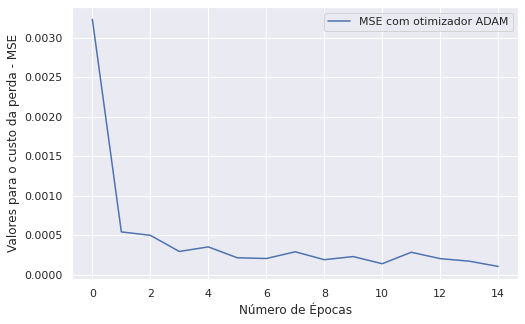

In [38]:
# Inicializando as variáveis
map_metric = 'loss'
lst_hist = [hist_ab_adam.history[map_metric]]
legend = ["MSE com otimizador ADAM"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores para o custo da perda - MSE'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

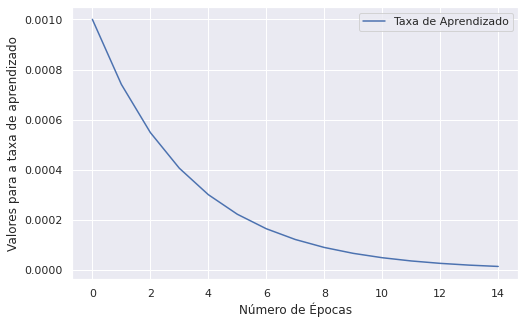

In [39]:
# Inicializando as variáveis
map_metric = 'lr'
lst_hist = [hist_ab_adam.history[map_metric]]
legend = ["Taxa de Aprendizado"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores para a taxa de aprendizado'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

<span style='color:black'>Inserí os gráficos de perda e da taxa de aprendizado apenas para ter uma visualização do que ocorreu durante o treinamento do modelo novo, model_ab.</span>

In [40]:
# Exiba precisão e revocação calculada no treinamento S e teste T
scoreS = model_ab.evaluate(S_x, S_y, verbose=0);
scoreT = model_ab.evaluate(T_x, T_y, verbose=0);

print(f'Cenário do Treinamento - Conjunto S:\n\tPrecisão  = '
      f'{scoreS[1]:.4f}\n\tRevocação = {scoreS[2]:.4f}\n'
      f'Cenário do Teste - Conjunto T:\n\tPrecisão  = '
      f'{scoreT[1]:.4f}\n\tRevocação = {scoreT[2]:.4f}')

Cenário do Treinamento - Conjunto S:
	Precisão  = 0.9231
	Revocação = 0.9600
Cenário do Teste - Conjunto T:
	Precisão  = 0.6899
	Revocação = 0.7982


#### Tentativa 2: SVM nos dados originais

In [41]:
# Antes de mais nada realizarei a padronização dos dados de treinamento
# Utilizarei o scaler que já foi treinado com o conjunto de Treinamento S_x
X_test_scaled = T_x.copy(deep=True)
X_test_scaled.iloc[:, :] = scaler.transform(T_x)

In [42]:
def ExecutarSVM(lst_c, x_train, y_train, x_test, y_test, exe_peso, dc_weight, kernel):
  #### Classificador SVM treinado nos dados originais S. 
  # Avalie precisão e revocação no treinamento S e teste T

  # Condição para avaliar se executará o modelo com peso ou sem para as classes
  if (exe_peso):
    # Percorrendo a lista de custos de C
    for c in lst_c:
      print(f'Cenário com o ajuste no parâmetro de custo C, setado para {c}')

      # Executar o método so SVM com a escolha dos parâmetros
      clf = SVC(C=c, random_state=1, class_weight=dc_weight, kernel=kernel)
      clf.fit(x_train, y_train)

      # Gerando a avaliação de precisão e recall do treinamento S
      Sy_train = clf.predict(x_train)

      precS = precision_score(y_train, Sy_train)
      revoS = recall_score(y_train, Sy_train)

      print(f'\n\tO resultado com o conjunto de treinamento, S, foi:\n\t\t'
            f'Precisão: {precS:.4f}\n\t\tRevocação: {revoS:.4f}')

      Ty_test = clf.predict(x_test)

      precT = precision_score(y_test, Ty_test)
      revoT = recall_score(y_test, Ty_test)

      print(f'\n\tO resultado com o conjunto de teste, T, foi:\n\t\t'
            f'Precisão: {precT:.4f}\n\t\tRevocação: {revoT:.4f}\n\n')
  else:
    # Percorrendo a lista de custos de C
    for c in lst_c:
      print(f'Cenário com o ajuste no parâmetro de custo C, setado para {c}')

      # Executar o método so SVM com a escolha dos parâmetros
      clf = SVC(C=c, random_state=1, kernel=kernel)
      clf.fit(x_train, y_train)

      # Gerando a avaliação de precisão e recall do treinamento S
      Sy_train = clf.predict(x_train)

      precS = precision_score(y_train, Sy_train)
      revoS = recall_score(y_train, Sy_train)

      print(f'\n\tO resultado com o conjunto de treinamento, S, foi:\n\t\t'
            f'Precisão: {precS:.4f}\n\t\tRevocação: {revoS:.4f}')

      Ty_test = clf.predict(x_test)

      precT = precision_score(y_test, Ty_test)
      revoT = recall_score(y_test, Ty_test)

      print(f'\n\tO resultado com o conjunto de teste, T, foi:\n\t\t'
            f'Precisão: {precT:.4f}\n\t\tRevocação: {revoT:.4f}\n\n')

**Cenário percorrendo a lista de custo C, sem peso para as classes e com o kernel linear**

In [43]:
# Criando lista do parâmetro de custo C
lst_c = [5e-1, 1, 5, 10, 15]
exe_peso = False
kernel = 'linear'
dc_weight = {0:1e-1, 1:9e-1}

ExecutarSVM(lst_c, X_train_scaled, S_y, X_test_scaled, T_y, exe_peso, dc_weight, kernel)

Cenário com o ajuste no parâmetro de custo C, setado para 0.5

	O resultado com o conjunto de treinamento, S, foi:
		Precisão: 1.0000
		Revocação: 0.9600

	O resultado com o conjunto de teste, T, foi:
		Precisão: 0.4500
		Revocação: 0.7668


Cenário com o ajuste no parâmetro de custo C, setado para 1

	O resultado com o conjunto de treinamento, S, foi:
		Precisão: 1.0000
		Revocação: 1.0000

	O resultado com o conjunto de teste, T, foi:
		Precisão: 0.3814
		Revocação: 0.7713


Cenário com o ajuste no parâmetro de custo C, setado para 5

	O resultado com o conjunto de treinamento, S, foi:
		Precisão: 1.0000
		Revocação: 1.0000

	O resultado com o conjunto de teste, T, foi:
		Precisão: 0.3839
		Revocação: 0.7713


Cenário com o ajuste no parâmetro de custo C, setado para 10

	O resultado com o conjunto de treinamento, S, foi:
		Precisão: 1.0000
		Revocação: 1.0000

	O resultado com o conjunto de teste, T, foi:
		Precisão: 0.3839
		Revocação: 0.7713


Cenário com o ajuste no parâmetro de 

**Cenário percorrendo a lista de custo C, com peso para as classes e com o kernel linear**

In [44]:
# Criando lista do parâmetro de custo C
lst_c = [5e-1, 1, 5, 10, 15]
exe_peso = True
kernel = 'linear'
dc_weight = {0:1e-1, 1:9e-1}

ExecutarSVM(lst_c, X_train_scaled, S_y, X_test_scaled, T_y, exe_peso, dc_weight, kernel)

Cenário com o ajuste no parâmetro de custo C, setado para 0.5

	O resultado com o conjunto de treinamento, S, foi:
		Precisão: 0.9259
		Revocação: 1.0000

	O resultado com o conjunto de teste, T, foi:
		Precisão: 0.4772
		Revocação: 0.7982


Cenário com o ajuste no parâmetro de custo C, setado para 1

	O resultado com o conjunto de treinamento, S, foi:
		Precisão: 0.9615
		Revocação: 1.0000

	O resultado com o conjunto de teste, T, foi:
		Precisão: 0.4223
		Revocação: 0.7803


Cenário com o ajuste no parâmetro de custo C, setado para 5

	O resultado com o conjunto de treinamento, S, foi:
		Precisão: 1.0000
		Revocação: 1.0000

	O resultado com o conjunto de teste, T, foi:
		Precisão: 0.3945
		Revocação: 0.7713


Cenário com o ajuste no parâmetro de custo C, setado para 10

	O resultado com o conjunto de treinamento, S, foi:
		Precisão: 1.0000
		Revocação: 1.0000

	O resultado com o conjunto de teste, T, foi:
		Precisão: 0.3839
		Revocação: 0.7713


Cenário com o ajuste no parâmetro de 

Nesta parte da sexta questão, apenas explorei no algoritmo do SVM, os diferentes valores para o custo (C). Além disso, abordei dois cenários:

1.   SVM sem os pesos nas classes.
2.   SVM com os pesos nas classes.


Após o C = 1, os demais valores dos custos tiveram resultados semelhantes, no cenário sem o pesos nas classes, e embora os resultados nos digam que no treinamento acertou tudo, levando a um possível overfitting. Pareceu que os pesos maiores não tiveram efeito neste caso, sendo que para este problema entre os pesos 0.5 e 1 foram o que apresentaram algo de diferente.

Já no cenario com os pesos, embora tivemos uma pequena piora, na métrica de precisão para o conjunto de teste, os resultados que me aparentemente tiveram efeitos foram com o custo 0.5 e 1. Lembrando ainda que o conjunto de treinamento teve um resultado perfeito a partir do custo 5.

Para a tentativa 3, usarei somente os custos 0.5 e 1. Os demais custos não tiveram efeitos que pudéssemos explorá-los.

Observação: explorei o método do SVM com o kernel linear porque para o conjunto de dados utilizado, S, o problema era de classificação binária.

#### Tentativa 3: Camada de código do modelo DNN + SVM

In [45]:
# Classificador SVM treinado nos dados S obtendo sua representação do código da rede de classificação (modelo B). 
# Avalie precisão e revocação no treinamento S e teste T

# Eu vou obter o modelo na camada do espaço latente/código/embedding
code_model = keras.models.Model(model_b_adam.input, model_b_adam.layers[-2].output)

code_train = np.asarray(code_model.predict(S_x))
code_test  = np.asarray(code_model.predict(T_x))

print(f'Conjunto S - treinamento = {code_train.shape}\n'
      f'Conjunto T - teste = {code_test.shape}')

Conjunto S - treinamento = (7120, 28)
Conjunto T - teste = (142404, 28)


In [46]:
# Executar o método do SVM
# Criando lista do parâmetro de custo C
lst_c = [5e-1, 1]
exe_peso = False
kernel = 'linear'
dc_weight = {0:1e-1, 1:9e-1}

ExecutarSVM(lst_c, code_train, S_y, code_test, T_y, exe_peso, dc_weight, kernel)

Cenário com o ajuste no parâmetro de custo C, setado para 0.5

	O resultado com o conjunto de treinamento, S, foi:
		Precisão: 1.0000
		Revocação: 0.9600

	O resultado com o conjunto de teste, T, foi:
		Precisão: 0.8424
		Revocação: 0.7668


Cenário com o ajuste no parâmetro de custo C, setado para 1

	O resultado com o conjunto de treinamento, S, foi:
		Precisão: 1.0000
		Revocação: 0.9600

	O resultado com o conjunto de teste, T, foi:
		Precisão: 0.7783
		Revocação: 0.7713




In [47]:
# Executar o método do SVM
# Criando lista do parâmetro de custo C
lst_c = [5e-1, 1]
exe_peso = True
kernel = 'linear'
dc_weight = {0:1e-1, 1:9e-1}

ExecutarSVM(lst_c, code_train, S_y, code_test, T_y, exe_peso, dc_weight, kernel)

Cenário com o ajuste no parâmetro de custo C, setado para 0.5

	O resultado com o conjunto de treinamento, S, foi:
		Precisão: 0.9231
		Revocação: 0.9600

	O resultado com o conjunto de teste, T, foi:
		Precisão: 0.8263
		Revocação: 0.7892


Cenário com o ajuste no parâmetro de custo C, setado para 1

	O resultado com o conjunto de treinamento, S, foi:
		Precisão: 0.9231
		Revocação: 0.9600

	O resultado com o conjunto de teste, T, foi:
		Precisão: 0.8373
		Revocação: 0.7848




Com o cenário com os pesos nas classes, observa que, ao obter a representação do conjunto S e do T do modelo e utilizá-lo no SVM, as métricas tiveram resultados mais satisfatórios. Por exemplo, no cenário sem peso tivémos a precisão com 100% no conjunto de treinamento.
Além disso, a diferença entre os custos, 0.5 e 1, foram pequenas e foram somente no conjunto de testes essa alteração, sem comparar os cenários com ou sem peso. O conjunto de treinamento S não obteve nenhuma diferença.

Se compararmos com a primeira tentativa, fazendo a predição direta no modelo, tivemos alteração no conjunto de testes sendo:


1.   A precisão melhorada, passando de 69% para 82% e 84%, dependendo do parâmetro de custo.
2.   A revocação com um pouco de piora, passando de 80% para 79% ou 78%, dependendo do parâmetro de custo.

Portanto, as tentativas 1 e 3 tiveram um melhor desempenho em relação a tentativa 2 para esse tipo de problema. Inclusive, sendo a tentativa 3 a que obteve um desempenho mais satisfatório em relação as outras, mostrando a importância, em alguns cenários, a utilização de um classificador externo, após o treinamento em uma determinada rede neural.


